In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:04<00:00, 246MB/s]
100% 1.04G/1.04G [00:04<00:00, 231MB/s]


In [5]:
!unzip flickr8k.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/Images/2846037553_1a1de50709.jpg  
  inflating: /content/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/Images/2846843520_b0e6211478.jpg  
  inflating: /content/Images/2847514745_9a35493023.jpg  
  inflating: /content/Images/2847615962_c330bded6e.jpg  
  inflating: /content/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/Images/2848266893_9693c66275.jpg  
  inflating: /content/Images/2848571082_26454cb981.jpg  
  inflating: /content/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/Images/2848977044_446a31d86e.jpg  
  inflating: /content/Images/2849194983_2968c72832.jpg  
  inflating: /content/Images/2850719435_221f15e951.jpg  
  inflating: /content/Images/28511987

In [66]:
df = pd.read_csv("captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [67]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [68]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [69]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [70]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [71]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [72]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [73]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [74]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [75]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [76]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [77]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [78]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [79]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [80]:
train_samples = len(train)
print(train_samples)

36409


In [81]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [83]:
import random

class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/Images/' + str(image_name)

        img = Image.open(img_loc)


        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img


In [84]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [85]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [86]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [87]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [159]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [89]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [90]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [91]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [92]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [93]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [94]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [95]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [96]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

In [97]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

In [98]:
EPOCH = 30

In [99]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

<ipython-input-99-d3a928c6521d>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_val_loss = np.float('Inf')


In [100]:
import matplotlib.pyplot as plt


training_losses = []
validation_losses = []
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)


            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)


    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
    validation_losses.append(total_epoch_valid_loss)
    training_losses.append(total_epoch_train_loss)

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  5.362670421600342 Eval Loss ->  4.425593852996826
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.251058578491211 Eval Loss ->  4.01367712020874
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.9313955307006836 Eval Loss ->  3.8190221786499023
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.733928918838501 Eval Loss ->  3.6914849281311035
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.590571165084839 Eval Loss ->  3.597600221633911
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.47189998626709 Eval Loss ->  3.5262088775634766
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.3729095458984375 Eval Loss ->  3.468538999557495
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.2870612144470215 Eval Loss ->  3.4252960681915283
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.210664749145508 Eval Loss ->  3.387661933898926
Writing Model at epoch  8
Epoch ->  9  Training Loss ->  3

In [101]:
t_losses = [loss.cpu().item() for loss in training_losses]
v_losses = [loss.cpu().item() for loss in validation_losses]

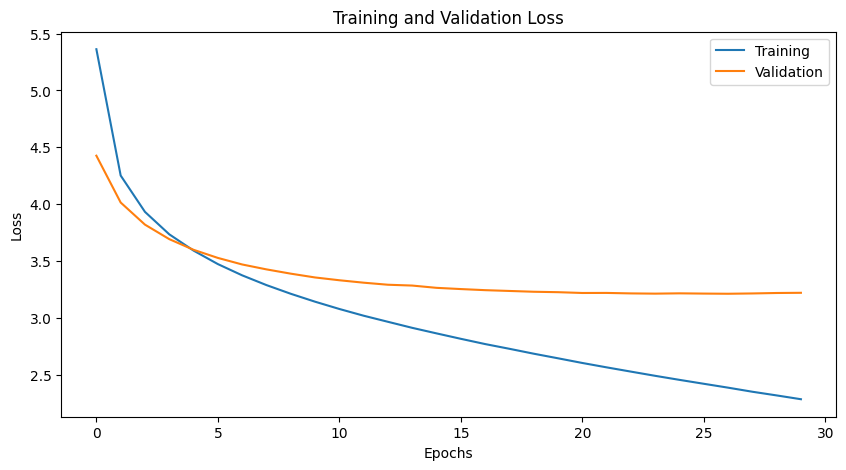

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(t_losses, label="Training")
plt.plot(v_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [103]:
model = torch.load('./BestModel')

start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [104]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [190]:
def generate_caption(K, img_nm):
    img_loc = 'Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    text = " ".join(predicted_sentence+['.'])
    print(text)
    return text

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


two people are sitting on the water at the beach .


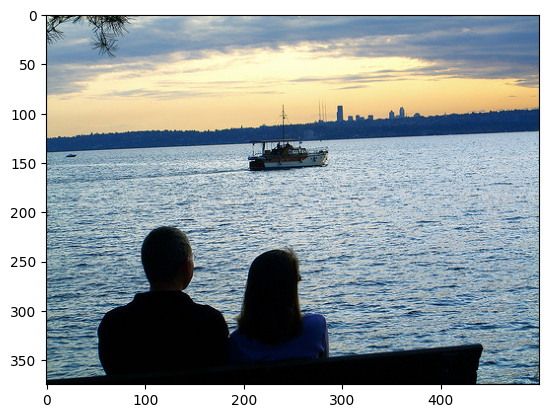

In [212]:
#!pip install gTTS
from gtts import gTTS
import io
from IPython.display import Audio

cap = generate_caption(1, unq_valid_imgs.iloc[17]['image'])
tts = gTTS(cap)
mp3_fp = io.BytesIO()
tts.write_to_fp(mp3_fp)
mp3_fp.seek(0)   # Play the audio
Audio(mp3_fp.read(),autoplay=True)